In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import warnings
warnings.simplefilter('ignore')

# Common code for display result
def show_graph(df1,df2,title):
    data = pd.concat([df1, df2])
    data.reset_index(inplace=True, drop=True)
    for col in data.columns:
        if col.lower().startswith('pred'):
            data[col].plot(label=col,linestyle="dotted")
        else:
            data[col].plot(label=col)
    plt.title(title)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
    plt.show()

In [6]:
# zori_zip = pd.read_csv('./Zillow_Data_direct/Zip_ZORI_AllHomesPlusMultifamily_SSA.csv')

# zip_county = pd.read_csv('https://raw.githubusercontent.com/scpike/us-state-county-zip/master/geo-data.csv')
# zip_county

In [8]:
# us_zips = pd.read_csv('uszips.csv')
# us_zips = us_zips[['zip', 'city', 'state_id', 'state_name','county_fips', 'county_name','county_names_all', 'county_fips_all']]

In [4]:
def fix_zip(series):
      return series.astype(str).str.replace('[^\w\s]', '').str.zfill(5)
#us_zips['fixed_zip'] = fix_zip(us_zips['zip'])

In [5]:
# pvt_tbl = zori_zip.pivot_table(columns='RegionName').drop(['RegionID','SizeRank'],axis=0)
# sorted(list(zip(pvt_tbl.columns,pvt_tbl.isnull().sum()/len(pvt_tbl))),key=lambda t:t[1],reverse=True)

In [6]:
mostly_clean_zori=pd.read_csv('./mostly_clean_zori.csv')
mostly_clean_zori.head(2)

,RegionName,Yr_Mo,RI,Year,Month,CountyName,zip_mean,zip_std,Outlier_High,Outlier_Low
0,10025,2014-01,2883.0,2014,1,New York County,2951.25,112.279389,False,False
1,10025,2014-02,2895.0,2014,2,New York County,2951.25,112.279389,False,False


In [7]:
#mostly_clean_zori[['RegionName','Yr_Mo','RI']]
mostly_clean_zori['RegionName']=fix_zip(mostly_clean_zori['RegionName'])
#mostly_clean_zori['RegionName']
pvt_tbl = mostly_clean_zori[['RegionName','Yr_Mo','RI']].pivot_table(columns='RegionName',values='RI',index='Yr_Mo',)

pvt_tbl.reset_index(inplace=True)
#pvt_tbl

In [8]:
train_lst = list(pvt_tbl['Yr_Mo'][:-17])
train_df = pvt_tbl[pvt_tbl['Yr_Mo'].isin(train_lst)]
train_df.set_index('Yr_Mo',drop=True,inplace=True)
test_df = pvt_tbl[~pvt_tbl['Yr_Mo'].isin(train_lst)]
test_df.set_index('Yr_Mo',drop=True,inplace=True)

#train_df
#test_df

In [29]:
xc = train_df[['10025','01603', '60657', '10023', '77494', '60614']]
yc = test_df[['10025','01603', '60657', '10023', '77494', '60614']]

[[3173.24626646 1259.44110438]
 [3172.52596685 1265.5121124 ]
 [3171.83767012 1271.23319793]
 [3171.18000385 1276.62347845]
 [3170.55165191 1281.70106855]
 [3169.95135233 1286.48313077]
 [3169.37789516 1290.98592404]
 [3168.83012051 1295.22484958]
 [3168.30691654 1299.21449471]
 [3167.80721757 1302.96867433]
 [3167.33000231 1306.50047047]
 [3166.8742921  1309.82226979]
 [3166.43914917 1312.94579924]
 [3166.0236751  1315.88216002]
 [3165.62700919 1318.64185972]
 [3165.24832697 1321.23484296]
 [3164.88683877 1323.67052044]]


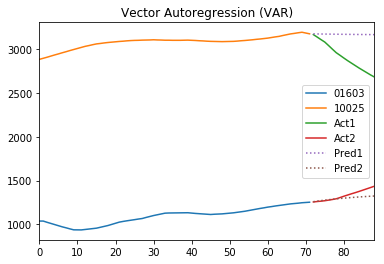

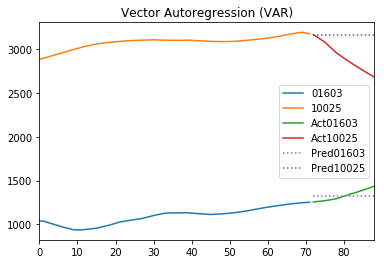

,Pred1,Pred2,Act1,Act2
0,3173.246266,1259.441104,3165.0,1256.000000
1,3172.525967,1265.512112,3137.0,1261.000000
2,3171.837670,1271.233198,3108.0,1265.000000
3,3171.180004,1276.623478,3080.0,1270.000000
4,3170.551652,1281.701069,3040.0,1277.000000
5,3169.951352,1286.483131,2999.0,1284.000000
6,3169.377895,1290.985924,2959.0,1292.000000
7,3168.830121,1295.224850,2929.0,1306.000000
8,3168.306917,1299.214495,2898.0,1321.000000
9,3167.807218,1302.968674,2868.0,1335.000000


In [19]:
from statsmodels.tsa.vector_ar.var_model import VAR
from random import random

def VAR_model(train,test):
    # fit model
    model = VAR(train)
    model_fit = model.fit()
    # make prediction
    yhat = model_fit.forecast(model_fit.y, steps=len(test))
    print(yhat)
    res1=pd.DataFrame({"Pred1":[x[0] for x in yhat],
                      "Pred2":[x[1] for x in yhat], 
                      "Act1":test["10025"].values,
                      "Act2":test["01603"].values})
    res2=pd.DataFrame({**{'Pred'+str(test.columns[i]):x[i] for x in yhat for i in range(len(x))},
                       **test.rename(columns={col_:'Act'+str(col_) for col_ in test.columns}).reset_index(drop=True).to_dict('series')})
    return res1, res2, yhat

# df_train = pd.DataFrame({'Act1':[x + random()*10 for x in range(0, 100)],
#                          'Act2':50+np.sin(np.linspace(0, 2*np.pi, 100))*50})
# df_test = pd.DataFrame({'Act1':[x + random()*10 for x in range(101, 201)],
#                          'Act2':50+np.sin(np.linspace(0, 2*np.pi, 100))*50})
df_ret1, df_ret2, yhat = VAR_model(xc, yc)
show_graph(xc, df_ret, "Vector Autoregression (VAR)")
show_graph(xc, df_ret2, "Vector Autoregression (VAR)")


In [17]:
yhat

res=pd.DataFrame({"Pred1":[x[0] for x in yhat],
                      "Pred2":[x[1] for x in yhat],
                      "Act1":test["10025"].values,
                      "Act2":test["01603"].values})


df = pd.DataFrame({ 'pred{}'.format(n):  [randint(0, 9) for x in range(num_rows)] for n in range(num_cols)}, 
                  index=[x+1 for x in range(num_rows)] , )

#     res=pd.DataFrame({**{'Pred'+str(test.columns[i]):x[i] for x in yhat for i in range(len(x))},
#                       **test.rename(columns={col_:'Act'+str(col_) for col_ in test.columns}).to_dict})


pd.DataFrame({})

array([[3173.24626646, 1259.44110438],
       [3172.52596685, 1265.5121124 ],
       [3171.83767012, 1271.23319793],
       [3171.18000385, 1276.62347845],
       [3170.55165191, 1281.70106855],
       [3169.95135233, 1286.48313077],
       [3169.37789516, 1290.98592404],
       [3168.83012051, 1295.22484958],
       [3168.30691654, 1299.21449471],
       [3167.80721757, 1302.96867433],
       [3167.33000231, 1306.50047047],
       [3166.8742921 , 1309.82226979],
       [3166.43914917, 1312.94579924],
       [3166.0236751 , 1315.88216002],
       [3165.62700919, 1318.64185972],
       [3165.24832697, 1321.23484296],
       [3164.88683877, 1323.67052044]])

In [25]:
from statsmodels.tsa.vector_ar.var_model import VAR
from random import random

def VAR_model(train,test):
    # fit model
    model = VAR(train)
    model_fit = model.fit()
    # make prediction
    yhat = model_fit.forecast(model_fit.y, steps=len(test))
    print(yhat)
#     res1=pd.DataFrame({"Pred1":[x[0] for x in yhat],
#                       "Pred2":[x[1] for x in yhat], 
#                       "Act1":test["10025"].values,
#                       "Act2":test["01603"].values})
#    preds = pd.DataFrame({'Pred'+str(train.columns[i]):x[i] for x in yhat for i in range(len(x))}, index)
    preds=pd.DataFrame(dict(zip(['Pred'+str(test.columns[i])for i in range(len(test.columns))],
                                [[x[i] for x in yhat] for i in range(len(x))])))
    preds = pd.DataFrame({train.rename(columns={col_:'Pred'+str(col_) for col_ in train.columns}).reset_index(drop=True).to_dict('series')})
    acts = pd.DataFrame({test.rename(columns={col_:'Act'+str(col_) for col_ in test.columns}).reset_index(drop=True).to_dict('series')})
#     res=pd.DataFrame({**{'Pred'+str(test.columns[i]):x[i] for x in yhat for i in range(len(x))},
#                        **test.rename(columns={col_:'Act'+str(col_) for col_ in test.columns}).reset_index(drop=True).to_dict('series')})
    return preds, acts, yhat

# df_train = pd.DataFrame({'Act1':[x + random()*10 for x in range(0, 100)],
#                          'Act2':50+np.sin(np.linspace(0, 2*np.pi, 100))*50})
# df_test = pd.DataFrame({'Act1':[x + random()*10 for x in range(101, 201)],
#                          'Act2':50+np.sin(np.linspace(0, 2*np.pi, 100))*50})
pred_df, acts_df, yhat = VAR_model(train_df, test_df)

# df_ret, yhat = VAR_model(train_df, test_df)
# show_graph(train_df, df_ret, "Vector Autoregression (VAR)")


[[1256.90624424 1377.22601921 1292.42071252 ... 1186.771896
  1359.58238822  962.15940491]
 [1262.45020921 1382.94736808 1299.18904229 ... 1191.10895902
  1366.43644695  966.58077014]
 [1267.43967375 1388.65270959 1306.32943431 ... 1195.66790068
  1373.61681429  972.2139076 ]
 ...
 [1275.59178707 1467.75025734 1376.5541423  ... 1241.3602057
  1476.63857855 1034.46616447]
 [1272.81477619 1470.56119248 1385.99130681 ... 1246.88390883
  1484.45714365 1042.48806146]
 [1269.16247821 1472.57413435 1394.51779145 ... 1252.86712869
  1490.12349682 1050.78802945]]


TypeError: unhashable type: 'dict'

[[3177.92856145 1258.39781852 1724.9414237  3368.00998079 1538.72280658
  1970.17889078]
 [3182.22070877 1263.45003554 1728.03034997 3373.31214694 1542.74652612
  1974.57080749]
 [3186.89085705 1268.25767821 1731.2647094  3378.91360496 1547.05722814
  1979.18406868]
 [3191.95374819 1272.93035385 1734.64532488 3384.82285767 1551.63544402
  1984.02794143]
 [3197.4236745  1277.58215099 1738.17587706 3391.04928212 1556.45720239
  1989.1126027 ]
 [3203.31379139 1282.32771083 1741.8627541  3397.60262699 1561.49516129
  1994.44905182]
 [3209.63553843 1287.2785978  1745.71480267 3404.49254795 1566.7197878
  2000.04898293]
 [3216.39818282 1292.54007561 1749.7429988  3411.7281962  1572.10053799
  2005.92462688]
 [3223.60849297 1298.2083717  1753.96005895 3419.31787222 1577.6069942
  2012.08857279]
 [3231.27054481 1304.36848771 1758.38001173 3427.26875312 1583.20992192
  2018.5535788 ]
 [3239.3856581  1311.09258943 1763.01775062 3435.58669852 1588.88221448
  2025.3323816 ]
 [3247.95245553 1318.43

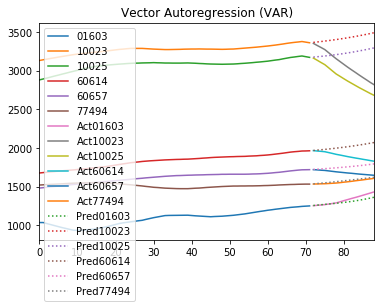

In [32]:
from statsmodels.tsa.vector_ar.var_model import VAR
from random import random

def VAR_model(train,test):
    # fit model
    model = VAR(train)
    model_fit = model.fit()
    # make prediction
    yhat = model_fit.forecast(model_fit.y, steps=len(test))
    print(yhat)
#     res1=pd.DataFrame({"Pred1":[x[0] for x in yhat],
#                       "Pred2":[x[1] for x in yhat], 
#                       "Act1":test["10025"].values,
#                       "Act2":test["01603"].values})
#    preds = pd.DataFrame({'Pred'+str(train.columns[i]):x[i] for x in yhat for i in range(len(x))}, index)
#     preds=pd.DataFrame(dict(zip(['Pred'+str(test.columns[i])for i in range(len(test.columns))],
#                                 [[x[i] for x in yhat] for i in range(len(x))])))
#     preds = pd.DataFrame({train.rename(columns={col_:'Pred'+str(col_) for col_ in train.columns}).reset_index(drop=True).to_dict('series')})
#     acts = pd.DataFrame({test.rename(columns={col_:'Act'+str(col_) for col_ in test.columns}).reset_index(drop=True).to_dict('series')})
    res=pd.DataFrame({**dict(zip(['Pred'+str(test.columns[i])for i in range(len(test.columns))],
                                 [[x[i] for x in yhat] for i in range(len(yhat[0]))])),
                      **test.rename(columns={col_:'Act'+str(col_) for col_ in test.columns}).
                      reset_index(drop=True).to_dict('series')})
    return res, yhat

# df_train = pd.DataFrame({'Act1':[x + random()*10 for x in range(0, 100)],
#                          'Act2':50+np.sin(np.linspace(0, 2*np.pi, 100))*50})
# df_test = pd.DataFrame({'Act1':[x + random()*10 for x in range(101, 201)],
#                          'Act2':50+np.sin(np.linspace(0, 2*np.pi, 100))*50})
df_ret, yhat = VAR_model(xc, yc)

# df_ret, yhat = VAR_model(train_df, test_df)
show_graph(xc, df_ret, "Vector Autoregression (VAR)")


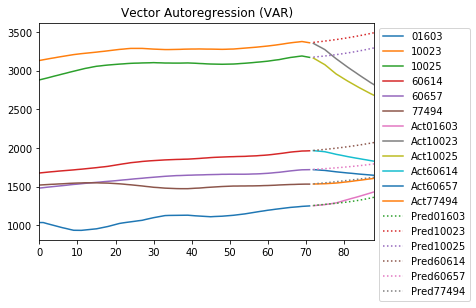

In [34]:
from statsmodels.tsa.vector_ar.var_model import VAR
from random import random


def show_graph(df1,df2,title):
    data = pd.concat([df1, df2])
    data.reset_index(inplace=True, drop=True)
    for col in data.columns:
        if col.lower().startswith('pred'):
            data[col].plot(label=col,linestyle="dotted")
        else:
            data[col].plot(label=col)
    plt.title(title)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
    plt.show()
    

def VAR_model(train,test):
    # fit model
    model = VAR(train)
    model_fit = model.fit()
    # make prediction
    yhat = model_fit.forecast(model_fit.y, steps=len(test))
    res=pd.DataFrame({**dict(zip(['Pred'+str(test.columns[i])for i in range(len(test.columns))],
                                 [[x[i] for x in yhat] for i in range(len(yhat[0]))])),
                      **test.rename(columns={col_:'Act'+str(col_) for col_ in test.columns}).
                      reset_index(drop=True).to_dict('series')})
    return res, yhat
df_ret, yhat = VAR_model(xc, yc)

show_graph(xc, df_ret, "Vector Autoregression (VAR)")